# Coreference Relationships in Conversational Question Answering

In [1]:
# disable logging.
import logging, sys
logging.disable(sys.maxsize)

In [17]:
%matplotlib inline

import re
import math
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
from allennlp.predictors.predictor import Predictor
from allennlp.data.tokenizers import word_tokenizer

In [4]:
# load models and data
coref = Predictor.from_path("https://s3-us-west-2.amazonaws.com/allennlp/models/coref-model-2018.02.05.tar.gz")
tokenizer = word_tokenizer.WordTokenizer()
ds = json.load(open("coqa-dev-v1.0.json"))
scores = pd.read_json("output/score_per_instance.json")

def get_story_id(r):
    for idx, item in enumerate(ds["data"]):
        if item["id"] == r.id:
            return idx
scores["story_id"] = scores.apply(get_story_id, axis=1)

In [5]:
def pack_paragraph_and_qa(item):
    """Joins paragraph, question and answers: Passage<sep>Q1<sep>A1<sep>Q2<sep>A2.."""
    packed = []
    qspans, aspans = [], []
    for q, a in zip(item["questions"], item["answers"]):
        qstart = len(packed)
        packed.extend([t.text for t in tokenizer.tokenize(q["input_text"])])
        qend = len(packed)
        packed.extend([t.text for t in tokenizer.tokenize(a["span_text"])]);
        aend = len(packed)
        qspans.append((qstart, qend))  # end is excluded.
        aspans.append((qend, aend)) # end is excluded
    return packed, qspans, aspans

def is_span(A, B):
    # `A(start, end)` is a span of `B(start, end)?
    #return (B[0] - 50 <= A[0] <= B[1] + 50) and (A[1]-50 <= B[1] + 50)
    return B[0] <= A[0]

def find_coref_relations_in_qa(story_id):
    """Find undirected coreference relations between questions of a passage."""
    # join passage, Q and A; adjusted answer spans
    item = ds["data"][story_id]
    packed_qa, q_spans, a_spans = pack_paragraph_and_qa(item)
    
    # prepare undirected relation pairs (Q1, Q2)
    relations = set()
        
    # resp has clusters. each cluster is a list of spans representing a particular coref.
    # QAs corresponding to each cluster are related.
    resp = coref.predict_tokenized(packed_qa)
    
    # span belongs to which Q and A?
    def span_to_qa(cluster_span):
        for idx in range(len(q_spans)-1, -1, -1):
            qa_start, qa_end = q_spans[idx][0], a_spans[idx][1]
            if is_span(cluster_span, (qa_start, qa_end)):
                return idx
    
    # questions corresponding to spans of a cluster are related.
    for cluster in resp["clusters"]:
        related_questions = set()
        for cluster_span in cluster:
            qid = span_to_qa(cluster_span)
            if qid is not None:
                related_questions.add(qid)
        
        # create (q1, q2) pairs from related questions list.. [q1, q2 .. qn]
        # these pairs are needed for heatmaps
        for rel in itertools.combinations(related_questions, 2):
            rel = tuple(sorted(rel))
            relations.add(rel)
    # NOTE: if Q1[word-A] -> Passage[Word-B], Q2[word-B] -> Passage[word-B].. then 
    # *may be* Q1 and Q2 are related.. This is not calculated.. it may do more error..
    return relations

In [12]:
def make_heatmap(story_id, relations=None, map_size=None):
    item = ds["data"][story_id]
    if map_size is None:
        map_size = len(item["questions"])
    if relations is None:
        relations = find_coref_relations_in_qa(story_id)
    heatmap = np.zeros((map_size, map_size))
    for rel in relations:
        heatmap[rel] = 1
    return heatmap

In [22]:
def print_passage(story_id):
    item = ds["data"][story_id]
    print(">> Passage ")
    print(item["story"], "\n\n")
    for idx, (q, a) in enumerate(zip(item["questions"], item["answers"])):
        print(">> ", idx)
        print(q["input_text"])
        print(a["span_text"])
        print()

## An example story and its coreference relations

Relation(Question_ID, Question_ID):  {(2, 7), (4, 10), (4, 9), (4, 8), (4, 5), (8, 10), (0, 7), (8, 9), (9, 10), (2, 3), (3, 7), (0, 3), (0, 2)} 


Reference: 


>>  0
what was the name of the fish
 Asta.

>>  1
What looked like a birds belly
a bottle

>>  2
who said that
 "It looks like a bird's belly," said Asta.

>>  3
Was Sharkie a friend?
Asta's friend Sharkie

>>  4
did they get the bottle?
So they caught the bottle

>>  5
What was in it
 It was a note.

>>  6
Did a little boy write the note
This note is from a little girl

>>  7
Who could read the note
Asta's papa read the note

>>  8
What did they do with the note
unknown

>>  9
did they write back
we can write a note to her. But you have to find another bottle so we can send it to her." And that is what they did.

>>  10
were they excited
unknown

Heatmap: 




Text(0.5,1,'Yellow indicates coref relation b/w questions')

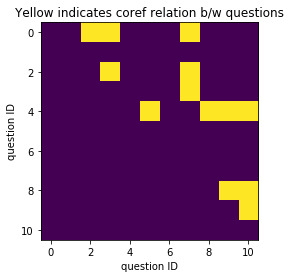

In [15]:
# example..
story_id = 1
num_questions = len(item["questions"])

relations = find_coref_relations_in_qa(story_id)
print("Relation(Question_ID, Question_ID): ", relations, "\n\n")

print("Reference: \n\n")
for idx in range(num_questions):
    print(">> ", idx)
    print(ds["data"][story_id]["questions"][idx]["input_text"])
    print(ds["data"][story_id]["answers"][idx]["span_text"])
    print()
    
print("Heatmap: \n\n")
heatmap = make_heatmap(story_id)
plt.imshow(heatmap)
plt.xlabel("question ID")
plt.ylabel("question ID")
plt.title("Yellow indicates coref relation b/w questions")

# Create a random sample to conduct experiments
_Note: Increase the sample size ratio to 1.. to take full dataset._

In [49]:
## These variables are used future cells.
num_stories = len(ds["data"])
sample_size_ratio = 0.50  # 10% of total dataset..

# prepare sample
sample_size = int(num_stories * sample_size_ratio)
sample_stories = random.sample(range(num_stories), sample_size)

print("sample size: ", sample_size)

sample size:  250


In [28]:
def plot_multiple_heatmaps(stories, limit=10):
    # set limit to None, to plot all stories..
    limit = limit or len(stories)
    heatmaps = [make_heatmap(sid) for sid in stories]
    counter = 0
    cols = 5
    rows = math.ceil(limit / cols)
    fig, ax = plt.subplots(rows, cols, figsize=(10 * rows, 10))

    for r in range(rows):
        for c in range(cols):
            if counter == limit:
                break
            # note: maybe we need to normalize.. for KNN.
            ax[r][c].imshow(heatmaps[counter])
            # axis labels
            story_id = sample_stories[counter]
            map_size = len(ds["data"][story_id]["questions"])
            ax[r][c].set_xticks(np.arange(map_size))
            ax[r][c].set_yticks(np.arange(map_size))
            ax[r][c].set_xticklabels(np.arange(map_size) + 1)
            ax[r][c].set_yticklabels(np.arange(map_size) + 1)
            # title
            ax[r][c].set_title("Story: %s" % story_id)
            # counter
            counter += 1
        if counter == limit:
            break

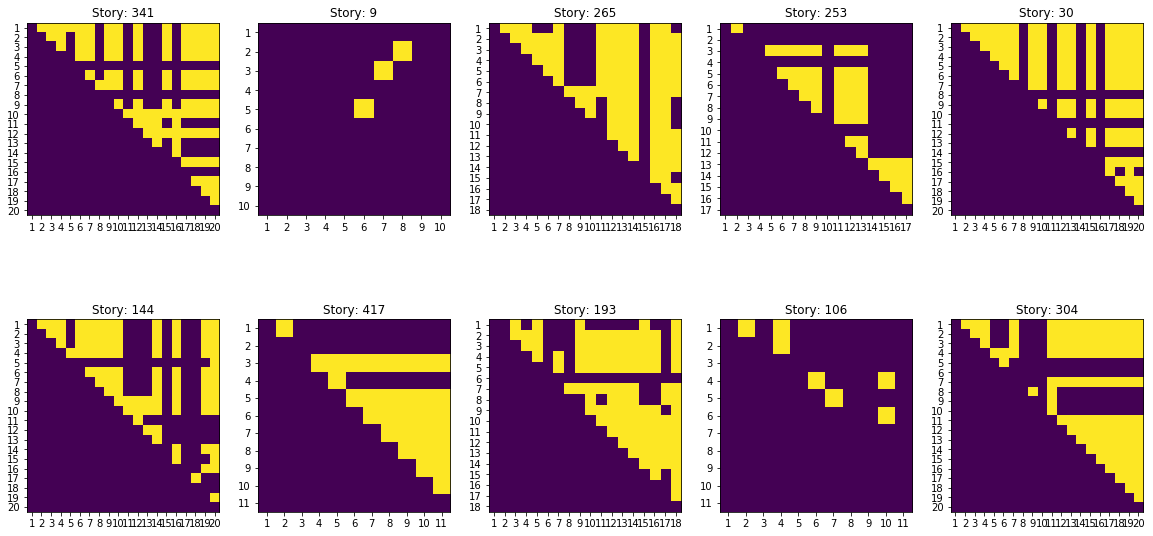

In [29]:
plot_multiple_heatmaps(sample_stories)

# Coreference Ratio

Number of relation pairs (q1, q2) in each passage.

Higher the number implies, language is highly connected.

If there are N questions in passage, the range of measure is [0, N * N-1]

# Relation Ratio

Number of questions that are at least related to another questions.

Higher the number implies, questions highly related to one another.

If there are N questions in passage, the range of measure is [0, N]. *We normalize this to [0, 1].*

NOTE: Coreference ratio gives weightage to degree of relations. i.e., Higher degree if Q1 is related to more than one questions..

In [50]:
# create a dataframe containing story_id and relations.. (for future use..)
relations = []
for story_id in sample_stories:
    relations.append(find_coref_relations_in_qa(story_id))
relations_df = pd.DataFrame({"story_id": sample_stories, "relations": relations})

In [59]:
def relation_ratio(row):
    # num of questions in relations
    unique_questions_in_rel = set()
    for (q1, q2) in row.relations:
        unique_questions_in_rel.add(q1)
        unique_questions_in_rel.add(q2)
    tot_questions = len(ds["data"][row.story_id]["questions"])
    return len(unique_questions_in_rel)

def coreference_ratio(row):
    # num of questions in relations
    tot_questions = len(ds["data"][row.story_id]["questions"])
    return len(row.relations)

relations_df["rel_ratio"] = relations_df.apply(relation_ratio, axis=1)
relations_df["coref_ratio"] = relations_df.apply(coreference_ratio, axis=1)

In [52]:
# average F1 score per passage.
scores_story_grp = scores.groupby("story_id")["f1"].mean()
relations_df["f1_score"] = relations_df.apply(lambda row: scores_story_grp[row.story_id], axis=1)

### The spread of relation ratio in sample

Text(0,0.5,'Number of Questions')

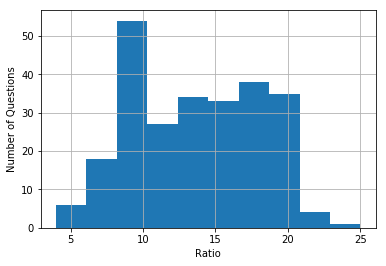

In [53]:
ax=relations_df.rel_ratio.hist()
ax.set_xlabel("Ratio")
ax.set_ylabel("Number of Questions")

### Coreference Ratio vs. F1 Score

Higher the coreference relationships, lesser the F1 score. 

_NOTE: Normalizing coref ratio to range [0, 1] may not give us an accurate picture. Because the model could only work robustly up to certain number of relations (as such number of questions in a conversation). We intent to know about that._

# TODO: compare with scores with human annotated answers?.

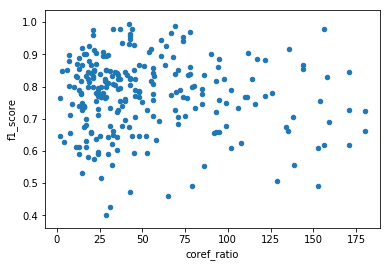

In [55]:
relations_df.plot.scatter(x="coref_ratio", y="f1_score")

### Relation Ratio vs F1 Score

The number of questions that have relationship with at least one question, seems to have very less on the F1 score. This is quite surprising when we look at the "coreference ratio vs. f1 score" plot where the relationship is more obvious. 

This seems to indicate that the number of coreferences within and between questions has more influence on F1 score, than question relationships.

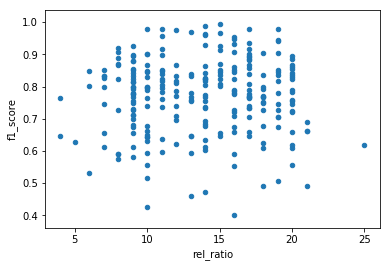

In [60]:
relations_df.plot.scatter(x="rel_ratio", y="f1_score")

# Experiment 1: Coreference Influence on F1 score

Related questiosn through coreference are clustered using a categorical label. 

This experiment seeks to know how much the existenance of relations among questions will influence the F1 score. Unlike the scatter plots, the weights of linear regression helps in identifying complex relationships.

Example: Let's say a passage has 6 questions [1 .. 6]. Consider that we established (1,2) and (3,5) and (2,4) are related. The feature X shall be represented as `X = [q1 q2 q3 q4 q5 q6]` with categorical variables `[1 1 2 1 2 0]`. Because (1,2) and (2,4) form cluster-1, (3,5) forms cluster 2, and by default cluster-0 is for unrelated ones.

```
Features:
 X = [1    1    0   2 2  ...] Each dimension represents a question. Questions of same cluster have same value
 Y = [0.01 0.02 1.0 1.0  ...] F1 score obtained on the question
```

In [61]:
# max number of questions across samples. this is required to fix the feature-X dimension.
max_num_questions = max(len(ds["data"][idx]["questions"]) for idx in sample_stories)

In [69]:
def create_feature_x(story_id):
    item = ds["data"][story_id]
    relations = relations_df[relations_df.story_id == story_id].relations.values[0]
    num_questions = len(item["questions"])
    
    # prepare X
    x = {}
    next_val = 0
    for (q1, q2) in relations:
        if x.get(q1) is None and x.get(q2) is None:
            x[q1] = x[q2] = next_val
            next_val += 1
        elif x.get(q1) is None:
            x[q1] = x[q2]
        elif x.get(q2) is None:
            x[q2] = x[q1]
    return [x.get(key, -1) for key in range(max_num_questions)]

In [83]:
X = np.stack(create_feature_x(story_id) for story_id in sample_stories)
Y = scores[scores.story_id.isin(sample_stories)].sort_values(["story_id"]).groupby("story_id")["f1"].mean().values

In [104]:
from sklearn.preprocessing import OneHotEncoder

onehot_categories = [np.arange(np.min(X), np.max(X)+1)] * max_num_questions
enc = OneHotEncoder(categories=onehot_categories, sparse=False)
X_hot=enc.fit_transform(X)
X_hot.shape

(250, 200)

### Linear Regression
40% of variability of F1 score is explained by the sequence of clusters.
**TODO: Need to think of better experiment..**

In [105]:
import statsmodels.api as sm
results = sm.OLS(Y, X_hot).fit()
results.summary()

/home/suryak/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/suryak/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/suryak/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/suryak/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                 -0.174
Method:                 Least Squares   F-statistic:                    0.7066
Date:                Fri, 22 Mar 2019   Prob (F-statistic):              0.973
Time:                        18:54:06   Log-Likelihood:                 252.34
No. Observations:                 250   AIC:                            -250.7
Df Residuals:                     123   BIC:                             196.5
Df Model:                         126                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0729      0.076     -0.960      0.339      -0.223       0.077
x2            -0.0575      0.077     -0.749      0.455      -0.209       0.094
x3            -0.0769      0.079     -0.975      0.332      -0.233       0.079
x4            -0.0395      0.081     -0.485      0.628      -0.201       0.122
x5            -0.0439      0.072     -0.608      0.545      -0.187       0.099
x6            -0.0341      0.101     -0.337      0.737      -0.234       0.166
x7             0.4385      0.405      1.082      0.281      -0.363       1.240
const      -1.168e-14   1.04e-14     -1.118      0.266   -3.24e-14    8.99e-15
x8             0.0573      0.080      0.721      0.473      -0.100       0.215
x9             0.0524      0.084      0.627      0.532      -0.113       0.218
x10            0.0217      0.080      0.271      0.787      -0.137       0.180
x11            0.0448      0.083      0.537      0.592      -0.120       0.210
x12           -0.0276      0.096     -0.288      0.774      -0.218       0.162
x13           -0.0154      0.118     -0.130      0.897      -0.249       0.219
x14           -0.0195      0.427     -0.046      0.964      -0.864       0.825
x15        -1.441e-16    1.1e-15     -0.130      0.896   -2.33e-15    2.04e-15
x16            0.0954      0.061      1.575      0.118      -0.025       0.215
x17            0.0797      0.054      1.480      0.141      -0.027       0.186
x18            0.0802      0.055      1.460      0.147      -0.029       0.189
x19            0.1110      0.061      1.827      0.070      -0.009       0.231
x20            0.0614      0.055      1.125      0.263      -0.047       0.169
x21            0.0748      0.083      0.904      0.368      -0.089       0.238
x22           -0.3887      0.300     -1.298      0.197      -0.982       0.204
x23         7.577e-16   1.53e-15      0.495      0.622   -2.27e-15    3.79e-15
x24           -0.0211      0.087     -0.244      0.808      -0.192       0.150
x25           -0.0401      0.081     -0.496      0.621      -0.200       0.120
x26           -0.0185      0.079     -0.233      0.816      -0.176       0.139
x27           -0.0309      0.080     -0.385      0.701      -0.190       0.128
x28           -0.0374      0.092     -0.405      0.686      -0.220       0.145
x29           -0.0818      0.115     -0.713      0.477      -0.309       0.145
x30            0.0861      0.233      0.369      0.713      -0.375       0.547
x31            0.2574      0.332      0.777      0.439      -0.399       0.914
x32           -0.0522      0.054     -0.968      0.335      -0.159       0.055
x33           -0.0432      0.050     -0.857      0.393      -0.143       0.057
x34           -0.0610      0.051     -1.205      0.231      -0.161       0.039
x35           -0.0857      0.058     -1.470      0.144      -0.201       0.030
x3

# Experiment 2: Stories that have similar relationships

KNN clustering on heatmaps

In [107]:
max_num_questions = max(len(ds["data"][i]["questions"]) for i in sample_stories)
heatmap_df = {"story_id": [], "heatmap": []}
for sid in sample_stories:
    heatmap_df["story_id"].append(sid)
    heatmap_df["heatmap"].append(make_heatmap(sid, map_size=max_num_questions))

In [108]:
from sklearn.neighbors import NearestNeighbors

# x -> 1-dim heatmap
X_hm = np.stack(heatmap_df["heatmap"])
X_hm = X_hm.reshape(X_hm.shape[0], -1)

# y -> story id corresponding to heatmap
y_hm = np.stack(heatmap_df["story_id"])

nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X_hm)
indices = nbrs.kneighbors(X_hm, return_distance=False)

In [109]:
knn_clusters = {}
for idx in indices:
    clus = idx[1]
    sid = idx[0]
    knn_clusters[clus] = knn_clusters.get(clus, [])
    knn_clusters[clus].append(sid)

In [110]:
knn_clusters

{31: [0, 7],
 211: [1],
 65: [2, 83, 225],
 178: [3],
 13: [4, 234],
 0: [5],
 230: [6, 27, 70, 87, 125],
 147: [8, 74],
 181: [9],
 101: [10],
 87: [11, 29, 39, 40, 58, 61, 92, 108, 111, 121, 136, 151, 181, 183, 220],
 235: [12, 16, 53, 227, 238],
 234: [13, 195],
 107: [14],
 191: [15, 117],
 219: [17, 205],
 74: [18, 147, 186],
 125: [19, 24, 37, 48, 52, 56, 90, 103, 122, 133, 230],
 238: [20, 180],
 86: [21, 193],
 186: [22, 112, 140, 163],
 213: [23],
 38: [25, 177],
 100: [26],
 245: [28],
 208: [30, 194],
 105: [31, 75, 89, 100],
 70: [32, 49, 189, 197],
 229: [33],
 43: [34],
 58: [35, 45, 106, 114, 155, 169, 174, 208],
 1: [36, 179, 211],
 69: [38, 131],
 248: [41, 82],
 174: [42, 204, 226],
 56: [43, 231],
 165: [44, 68],
 118: [46, 76, 127, 201],
 66: [47],
 33: [50, 104, 123, 229],
 202: [51, 110],
 158: [54],
 88: [55],
 209: [57, 150],
 85: [59],
 173: [60, 91, 135],
 49: [62],
 249: [63],
 96: [64, 247],
 60: [65, 173],
 47: [66],
 215: [67, 94, 160, 164, 206],
 131: [69

IndexError: list index out of range

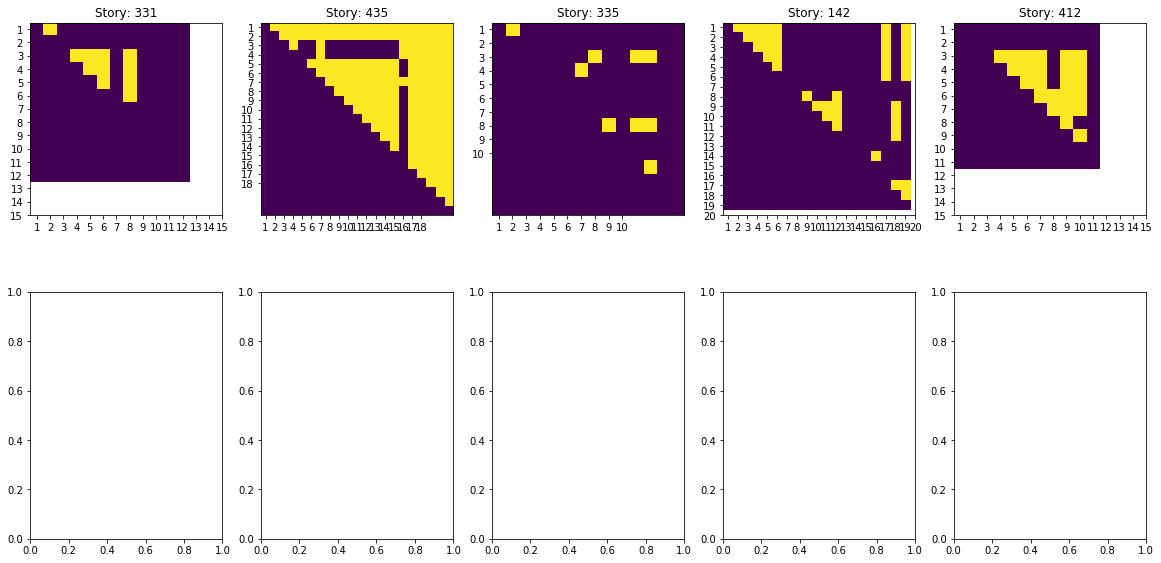

In [111]:
cluster_id = 235
cluster_stories = knn_clusters[cluster_id]
plot_multiple_heatmaps(cluster_stories)

In [330]:
print_passage(408)
print("______________")
print_passage(141)

>> Passage 
(CNN) -- He armors himself, keeps other people guessing and likes to wear a mask. 

Christian Bale is known as a hard worker who immerses himself in his characters. 

Batman? Try Christian Bale. 

Though in his case the armor and mask are metaphorical, the 34-year-old "Dark Knight" star likes to keep his personal life as shadowy as a superhero's back story. He's been known to keep a low profile -- "You will never see me at a party," he told the Times of London -- and delights in concocting stories about his life. 

"I make up [things]," he told Details magazine earlier this year. "Absolutely. I'm an actor -- I'm not a politician. I always kick myself when I talk too much about family, or personal things. I'll enjoy chatting now and then later I'll regret it." 

But with the explosive impact of "The Dark Knight" -- the film has set box office records in the 10 days since its release, becoming the fastest film to reach the $300 million mark in history -- and the forthcoming r